In [2]:
# import test_tensor_2d as tt ttbd
import quimb as qu
import quimb.tensor as qtn
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import itertools
import dense_qubits as dq
import exact_jwt
import stabilizers as stab
import qubit_networks as beeky
from itertools import product
import autoray
import scipy.sparse as sparse
import functools
import assorted_conts as ac
from quimb.utils import pairwise

In [264]:
reload(beeky)
T_, V_, MU_ = 1.0, 1.0, 2.0
qlat = dq.SpinlessHub(Lx=2, Ly=3)
mpoham = beeky.MPOSpinlessHam(qlat, T_, V_, MU_)
simham = beeky.SpinlessSimHam(qlat, T_, V_, MU_)

qnet = beeky.QubitEncodeVector.rand(qlat)
# mpo146 = mpoham._ham_terms[(1,4,6)]

# t0=qnet.apply_mpo(mpo=mpo146, where=(0,3,6), contract=True)


In [5]:
reload(dq)

##Testing params
T_PARAM=1
V_PARAM=2
MU_PARAM=0
LX, LY = 2, 3


### Analytical Hubbard Hamiltonian
hub = exactJWT.HubbardSpinless(Lx=LX, Ly=LY)
hub.build_spinless_ham(t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
Hexact = hub._Ham.copy()
gex, gsx = qu.eigh(Hexact)
print(f'Exact: {gex[0:3]}')

# nx = hub.state_occs(state=gsx[:,0])
# print(nx,end='\n\n')


### Qubit lattice Hamiltonian
sql = dq.SpinlessHub(Lx=LX,Ly=LY)
sql.make_simulator_ham(t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
simHam = sql.ham_sim()
sens, seigst = qu.eigh(simHam)
print(f'Nonstable: {sens[0:3]}')

sql.make_stabilizer()
codeHam = sql.ham_code()
rens, reigst = qu.eigh(codeHam)
print(f'Stable: {rens[0:3]}')

# print(sql.state_local_occs(k=None, qstate=Uplus@reigst[:,0]))

Exact: [-3.06118188 -2.41421356 -2.27945232]
Nonstable: [-3.18711224 -3.06118188 -2.41421356]
Stable: [-3.06118188 -2.41421356 -2.27945232]


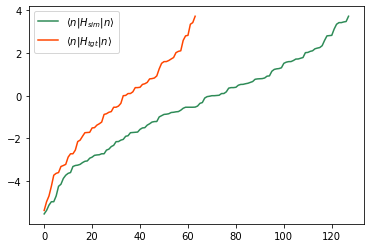

In [148]:
plt.plot(sens, label=r'$\langle n|H_{sim}|n\rangle$', color='seagreen')
plt.plot(rens, label=r'$\langle n|H_{tgt}|n\rangle$', color='orangered')
plt.legend()

***
**Imaginary time evolution**
***

Examine how changing the time-evolution Hamiltonian from the qubit Hamiltonian $H_{sim}$ to the "effective error-correcting" Hamiltonian $H_{master} = H_{sim} + H_{stab}$ changes the results.

* $H_{sim}$ has non-fermionic eigenstates, so imaginary-time evolution takes us out of the stable subspace and gives a "fake" non-fermionic ground state.

* $H_{master}$ includes a term to "incentivize" overlap with the stable subspace, which the imaginary-time evolution in the direction of the stable (fermionic) part of the Hilbert space.


In [29]:
reload(beeky)
reload(dq)

T_PARAM=1.0
V_PARAM=1.26
MU_PARAM=0.9

qlat = dq.SpinlessHub(Lx=2,Ly=3)
qlat.make_simulator_ham(t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
simHam = qlat.ham_sim()
sens, seigst = qu.eigh(simHam)
print(f'Nonstable: {sens[0:3]}')

qlat.make_stabilizer()
codeHam = qlat.ham_code()
rens, reigst = qu.eigh(codeHam)
print(f'Stable: {rens[0:3]}')

HSIM = beeky.SpinlessSimHam(qlat, t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
HSTAB = beeky.HamStab(qlat)
HMASTER = beeky.MasterHam(HSIM, HSTAB)

tensors = beeky.make_random_net(qlat)
net1 = beeky.QubitEncodeNet(tensors.copy(), qlat)
net2 = beeky.QubitEncodeNet(tensors.copy(), qlat)
net3 = beeky.QubitEncodeNet(tensors.copy(), qlat)

psi0 = net1.net_to_dense()
print('<H(0)>:  ',net1.compute_ham_expec(HSIM, normalize=True))


Nonstable: [-5.53274124 -5.37051838 -5.12289199]
Stable: [-5.37051838 -4.9630457  -4.69530491]
<H(0)>:   (-0.39340178657378766-6.816940951015129e-17j)


In [13]:
reload(beeky)

comp_fns = {'stab' : functools.partial(beeky.compute_encnet_ham_expec, ham = HSTAB),
            'norm':beeky.compute_encnet_normsquared,
            'sim': functools.partial(beeky.compute_encnet_ham_expec, ham=HSIM)  }

#MASTER evolve (fermionic)
tebd1 = beeky.iTimeTEBD(net1, ham=HMASTER, compute_every=50,compute_extra_fns=comp_fns)

#SIM evolve (non fermionic)
tebd2 = beeky.iTimeTEBD(net2, ham=HSIM, compute_every=50,compute_extra_fns=comp_fns)

#STAB then SIM (should be equiv to MASTER)
tebd3a = beeky.iTimeTEBD(net3, ham=HSTAB, compute_every=50, compute_extra_fns=comp_fns)
tebd3b = beeky.iTimeTEBD(net3, ham=HSIM, compute_every=50, compute_extra_fns=comp_fns)

n=2450, tau=0.01, energy~-5.370425: 100%|██████████| 2500/2500 [00:13<00:00, 182.23it/s]


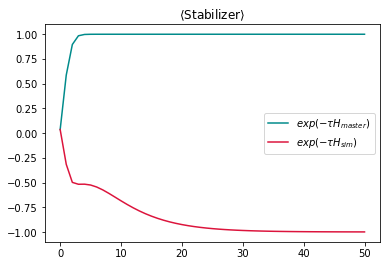

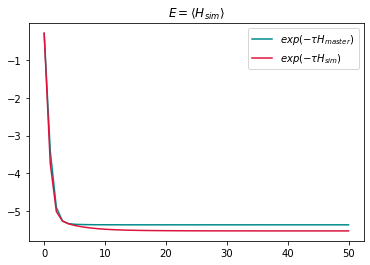

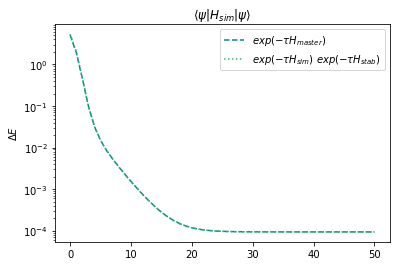

In [14]:
tebd1.evolve(2500)
tebd2.evolve(2500)
tebd3a.evolve(1000)
tebd3b.evolve(2500


masterstring = r'$exp(-\tau H_{master})$'
# masterstring = r'$U_{master}(\tau)$'
# simstring = r'$U_{sim}(\tau)$'
simstring = r'$exp(-\tau H_{sim})$'
stabstring = r' $exp(-\tau H_{stab})$'

# seqstring = r'$U_{sim}(\tau)$ $U_{stab}(T)$'

strs = {'master' : masterstring,
          'sim' : simstring,
          'seq' : simstring+stabstring
          }
colormap = {'master':'darkcyan',
            'sim' : 'crimson',
            'seq' : 'mediumseagreen'}          

# taus1 = tebd1.tau*np.array(tebd1.iters)
# taus2 = tebd2.tau*np.array(tebd1.iters)

plt.plot(-tebd1.get_final_data('Estab'),label=strs['master'], color=colormap['master'])
plt.plot(-tebd2.get_final_data('Estab'), label=strs['sim'], color=colormap['sim'])
# plt.plot(-tebd3a.get_final_data('Estab'),label=strs['seq'], color=colormap['seq'])
plt.title(r'$\langle$Stabilizer$\rangle$')
plt.legend()
plt.show()


plt.plot(tebd1.get_final_data('Esim'),label=strs['master'], color=colormap['master'])
plt.plot(tebd2.get_final_data('Esim'), label=strs['sim'], color=colormap['sim'])
# plt.plot(tebd3b.get_final_data('Esim'), label=strs['seq'], color=colormap['seq'])
plt.title(r'$E=\langle H_{sim}\rangle$')
plt.legend()
plt.show()



plt.semilogy((tebd1.get_final_data('Esim'))-rens[0],ls='dashed',label=strs['master'], color=colormap['master'])
plt.semilogy(tebd3b.get_final_data('Esim')-rens[0],ls='dotted', label=strs['seq'], color=colormap['seq'])
plt.ylabel(r'$\Delta E$')
# plt.hlines(y=rens[0], xmin=0, xmax=taus[-1], ls='dashed', colors='k')
plt.title(r'$\langle\psi|H_{sim}|\psi\rangle$')
plt.legend()
plt.show()




In [36]:
reload(stab)
reload(dq)

qlat = dq.SpinlessDense(Lx=2,Ly=3)
# code_dims = [2]*6
# sim_dims = [2]*7
U, Udag = stab.one_qubit_U_matrices(qlat, (0,1))
qlat.loop_stabilizer_data(0,1)

{'inds': (1, 2, 5, 4, 6), 'opstring': 'ZZZZX'}

***
**Local Product States**
***
Use `QubitEncodeVector.rand_local_product_state` to make a "local product state" where the vertex-face squares are internally entangled, but unentangled with the rest of the network. 

Right now the "product" bonds (i.e. zero entanglement bonds) are padded with zeros up to `d=2`, while the entangled bonds take `d=bond_dim`.

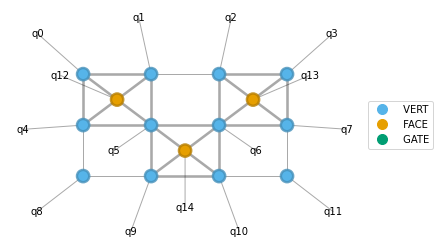

In [7]:
qvec = beeky.QubitEncodeVector.rand_local_product_state(Lx=3, Ly=4, phys_dim=2, bond_dim=6)
qvec.graph()

Now we want to test the norm contraction $\langle \psi|\psi\rangle$ for local product state (LPS) wavefunctions, which should have weaker entanglement compared to *random* wavefunctions.

In [117]:
reload(beeky)
LX, LY = (3, 4)
D_bond = 3

#medium entanglement
psi_lps = beeky.QubitEncodeVector.rand_local_product_state(Lx=LX, Ly=LY, bond_dim=D_bond)

#high entanglement
psi_rnd = beeky.QubitEncodeVector.rand(Lx=LX, Ly=LY, bond_dim=D_bond)

#make norm and rotate face tensors, since we are going to do BMPS
norm_lps = psi_lps.make_norm().setup_bmps_contraction_(layer_tags=('BRA', 'KET'))
norm_rnd = psi_rnd.make_norm().setup_bmps_contraction_(layer_tags=('BRA', 'KET'))

results = {'exact_lps': norm_lps^all, 'exact_rnd': norm_rnd^all, 'approx_lps':[], 'approx_rnd':[]}

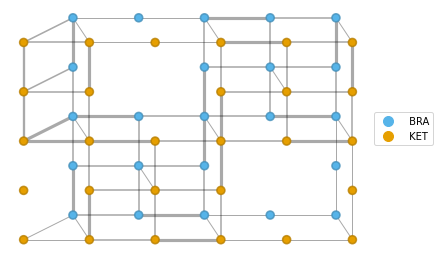

In [118]:
norm_lps.contract_boundary_from_left(xrange=(0,4), yrange=(0,1), layer_tags=('BRA', 'KET'), max_bond=5).graph_layers(color=("BRA", 'KET'))

In [119]:
for chi in range(2, 86, 2):
    nlps = norm_lps.contract_boundary(sequence=['b'], layer_tags=('BRA', 'KET'), max_bond=chi)
    results['approx_lps'].append((chi, nlps))
    nrnd = norm_rnd.contract_boundary(sequence=['b'], layer_tags=('BRA', 'KET'), max_bond=chi)
    results['approx_rnd'].append((chi, nrnd))

Text(0.5, 1.0, 'Initial bond $D=3$')

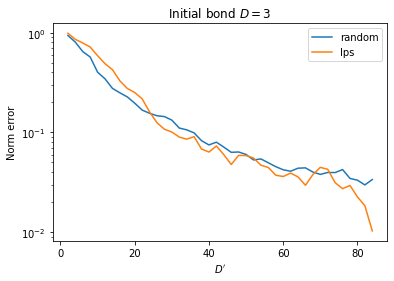

In [120]:
errs = dict({'psi_random': [], 'psi_lps': []})

for (chi, nrnd) in results['approx_rnd']:
    error = abs(1 - nrnd/results['exact_rnd'])
    errs['psi_random'].append((chi, error))
for (chi, nlps) in results['approx_lps']:
    error = abs(1 - nlps/results['exact_lps'])
    errs['psi_lps'].append((chi, error))
plt.semilogy(*zip(*errs['psi_random']), label='random')
plt.semilogy(*zip(*errs['psi_lps']), label='lps')
plt.legend()
plt.ylabel('Norm error')
plt.xlabel("$D'$")
plt.title(f"Initial bond $D={D_bond}$")
# plt.title(f'$D={D_bond}$')